# Stability of the RPN-signature to the regions-of-interest system

Initially, we import the required python modules and load the data (composite pain sensitivity, RPN-score, regional timeseries).

In [137]:
# import neccessary modules and load all data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
sns.set(style="ticks")
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from tqdm import tqdm as tqdm_base
# just a hack for a tqdm progress bar issue in python 2 notebooks
# https://github.com/tqdm/tqdm/issues/375
def tqdm(*args, **kwargs):
    if hasattr(tqdm_base, '_instances'):
        for instance in list(tqdm_base._instances):
            tqdm_base._decr_instances(instance)
    return tqdm_base(*args, **kwargs)

# Load all data:
study1 = pd.read_csv("../res/bochum_sample_excl.csv")[["HPT", "CPT", "MPT_log_geom",
                                                       "mean_QST_pain_sensitivity", "prediction"]]
study2 = pd.read_csv("../res/essen_sample_excl.csv")[["HPT", "CPT", "MPT_log_geom",
                                                      "mean_QST_pain_sensitivity", "prediction"]]
study3 = pd.read_csv("../res/szeged_sample_excl.csv")[["HPT", "CPT", "MPT_log_geom",
                                                       "mean_QST_pain_sensitivity", "prediction"]]
# merge datasets
df = pd.concat([study1, study2, study3])

# load the trained RPN-model
rpn = joblib.load("../res/predictive_model.sav")

# load features for each study
X_bochum = joblib.load("../res/feature_bochum.sav")
X_essen = joblib.load("../res/feature_essen.sav")
X_szeged = joblib.load("../res/feature_szeged.sav")

X=np.concatenate((X_bochum, X_essen, X_szeged))

## Step 1. Stability to region drop-out

Here, we investigate how robust the RPN-signature is to region drop-out, that is, artificially zeroing out the timecourse of a given number of RPN-regions.
On real data, a similar (although not so dramatic) drop-out can be caused e.g. by signal drop-out due to susceptibility artifact (typically in medial frontal regions).
We simulate drop out be zeroing out N regions randomly and plot the histogram of correlations of the RPN-scores computed with random drop-out (drop-out score) with the measured composite pain sensitivity.

First, we define a function to perform the "drop-out" of a given number of regions.

In [138]:
def drop_out_region(num_drop_out=0):
    #load atlas labels
    labels = pd.read_csv("../data/atlas_relabeled.tsv", sep="\t")[["index", "labels", "modules"]]
    labels.loc[-1] = [0, "aMEAN_GM", "aMEAN_GM"]  # adding a row
    labels.index = labels.index + 1  # shifting index
    labels = labels.sort_index()  # sorting by index

    # get coefficients of the RPN
    RES = np.zeros(len(labels)*(len(labels)-1)/2)
    featuremask = rpn.named_steps['fsel'].get_support()
    RES[featuremask] = rpn.named_steps['model'].coef_
    
    # zero-out some regions by randomly selecting from those having a nonzero coef
    indices=np.random.choice(np.nonzero(RES)[0], num_drop_out, replace=False)
    X_drop=X.copy()
    X_drop[:, indices]=0
    
    predicted = rpn.predict(X_drop)
    return(predicted)

Next, we investigate how the correlation changes for various drop-out values.

In [139]:
numiter=50
max_drop_N=22
num_dropped=np.zeros(max_drop_N*numiter)
correlation=np.zeros(max_drop_N*numiter)

np.random.seed(0)
idx=0
for dropN in tqdm(range(max_drop_N)):
    for iter in range(numiter):
        
        correlation[idx] = np.corrcoef(df['mean_QST_pain_sensitivity'], drop_out_region(dropN))[0,1]
        num_dropped[idx]=dropN
        idx=idx+1

data=pd.DataFrame({
    'num_dropped' : num_dropped,
    'correlation' : correlation
})



100%|██████████| 22/22 [01:09<00:00,  3.17s/it]


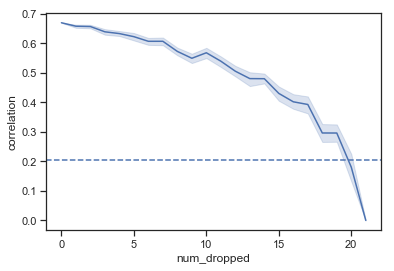

In [140]:
# plot drop-out effect
ax=sns.lineplot(x="num_dropped", y="correlation", ci=95, data=data)
ax.axhline(0.2061, ls='--')
plt.show()

### *Figure SE2.1. The tolerance of the RPN-signature to region drop-out.*
*The mean (and 95% confidence intervals) correlation between predicted and observed pain sensitivity is plotted as a function of the number of regions dropped out randomly by setting their timecourse to constant zero. Dashed line denotes R=0.206, i.e. the correlation value belonging to the p=0.05 significance threshold. The analysis revealed a considerable robustness to drop-out; the average prediction accuracy remained significant by the random drop-out of up to 19 regions out of 21, although – as expected - prediction accuracy constantly decreased with an increasing number of dropped regions.*


## Step 2. Stability to the definition region-boundaries (mixed signal)

Next to full drop-out of some of the regions another issue on the level of the regional timeseries can be a decreased signal-to-noise ratio. Such an effect can be caused, for instance, by a generally low measurement quality or a less accurate definition of regions (e.g. co-registration inaccuracies or use of another brain atlas).

First, we define a function to add a given proportion of Gaussian noise to *all* of the regional timeseries.
>new_timeseries = original_timeseries + noise_weight * Guassian_random(mean(original_timeseries), sd(original_timeseries))

- noise_weight = 0 means no additional noise at all,
- noise_weight = 1 means an equal amount of original signal and additional noise

In [141]:
def mix_region(mixing_weight=0):
    X_noisy=X.copy()
    scaler = StandardScaler()
    scaler.fit(X_noisy)
    X_noisy = X_noisy + mixing_weight * np.random.normal(scaler.mean_, scaler.scale_, X_noisy.shape)
    predicted = rpn.predict(X_noisy)
    return(predicted)

Next, we investigate how prediction accuracy changes as a function of the amount of noise.

In [142]:
numiter=50
weights=np.linspace(start=0, stop=5, num=10)
noise_weight=np.zeros(len(weights)*numiter)
correlation=np.zeros(len(weights)*numiter)

np.random.seed(0)
idx=0
for w in tqdm(weights):
    for iter in range(numiter):  
        correlation[idx] = np.corrcoef(df['mean_QST_pain_sensitivity'], mix_region(w))[0,1]
        noise_weight[idx] = w
        idx=idx+1

data=pd.DataFrame({
    'noise_weight' : noise_weight,
    'correlation' : correlation
})

100%|██████████| 10/10 [00:22<00:00,  2.24s/it]


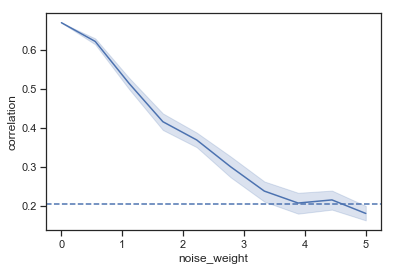

In [118]:
# plot drop-out effect
ax=sns.lineplot(x="noise_weight", y="correlation", ci=95, data=data)
ax.axhline(0.2061, ls='--')

plt.show()

### *Figure SE2.2. The tolerance of the RPN-signature to noise added to the regional timecourses.*
*The mean correlation (and 95% confidence intervals) between predicted and observed pain sensitivity is plotted as a function of the amount of noise added to all timecourses, simultaneously. Dashed line denotes R=0.206, i.e. the correlation value belonging to the p=0.05 significance threshold.*